   zone_id  year  month  day      h1      h2      h3      h4      h5      h6  \
0        1  2004      1    1  16,853  16,450  16,517  16,873  17,064  17,727   
1        1  2004      1    2  14,155  14,038  14,019  14,489  14,920  16,072   
2        1  2004      1    3  14,439  14,272  14,109  14,081  14,775  15,491   
3        1  2004      1    4  11,273  10,415   9,943   9,859   9,881  10,248   
4        1  2004      1    5  10,750  10,321  10,107  10,065  10,419  12,101   

   ...     h15     h16     h17     h18     h19     h20     h21     h22  \
0  ...  13,518  13,138  14,130  16,809  18,150  18,235  17,925  16,904   
1  ...  16,127  15,448  15,839  17,727  18,895  18,650  18,443  17,580   
2  ...  13,507  13,414  13,826  15,825  16,996  16,394  15,406  14,278   
3  ...  14,207  13,614  14,162  16,237  17,430  17,218  16,633  15,238   
4  ...  13,845  14,350  15,501  17,307  18,786  19,089  19,192  18,416   

      h23     h24  
0  16,162  14,750  
1  16,467  15,258  
2  13,315  12,

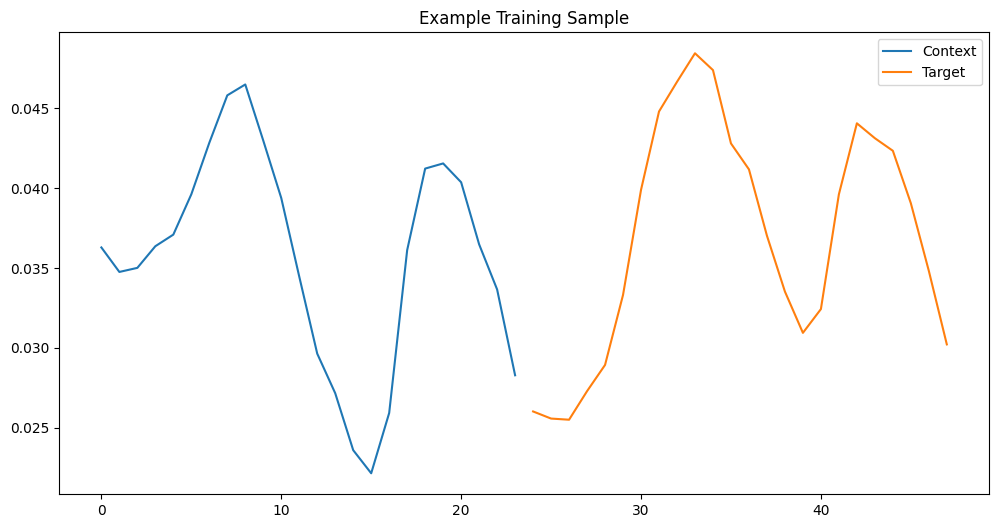

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Load and preprocess the data
df = pd.read_csv("Load_demand_data.csv")

# Check the first few rows
print(df.head())

# Reshape the data to long format
df_long = df.melt(id_vars=['zone_id', 'year', 'month', 'day'],
                  value_vars=[f'h{i}' for i in range(1, 25)],
                  var_name='hour', value_name='value')

df_long['hour'] = df_long['hour'].str.extract('(\d+)').astype(int)
df_long['datetime'] = pd.to_datetime(df_long[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1)) \
    + pd.to_timedelta(df_long['hour'] - 1, unit='h')
df_long = df_long.drop(columns=['year', 'month', 'day', 'hour'])
df_long = df_long[['zone_id', 'datetime', 'value']]
df_long = df_long.sort_values(by=['zone_id', 'datetime']).reset_index(drop=True)

print(df_long.head()) # To check if the data is cleaned

# Clean the 'value' column by removing commas and converting to float

if pd.api.types.is_numeric_dtype(df_long['value']):
    df_long['value'] = df_long['value'].astype(float) # If 'value' is of numeric type, simply convert it to float

else:
    df_long['value'] = df_long['value'].str.replace(',', '').astype(float) # If 'value' is not numeric, then assume it's string


# Normalize the 'value' column for each zone_id separately
scaler = MinMaxScaler(feature_range=(0, 1))
df_long['value_normalized'] = df_long.groupby('zone_id')['value'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).ravel()
)
# Check if the data is scaled
print(df_long.head())

# Create sequences for time series forecasting
def create_sequences(data, sequence_length, target_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length - target_length + 1):
        x = data[i:(i + sequence_length)]
        y = data[(i + sequence_length):(i + sequence_length + target_length)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence and target lengths
sequence_length = 24  # Use 24 hours (1 day) as input sequence
target_length = 24    # Predict the next 24 hours (1 day)

# Prepare data for each zone_id
zone_ids = df_long['zone_id'].unique()
X_all, y_all = [], []

for zone_id in zone_ids:
    zone_data = df_long[df_long['zone_id'] == zone_id]['value_normalized'].values
    X, y = create_sequences(zone_data, sequence_length, target_length)
    X_all.append(X)
    y_all.append(y)

# Concatenate data from all zones
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Reshape X_train and X_test to match the expected input shape for models
X_train = X_train.unsqueeze(-1)  # Add feature dimension
X_test = X_test.unsqueeze(-1)    # Add feature dimension

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Verify your data
print(f"Training data shape: {X_train.shape}")  # Should be (num_samples, context_length, 1)
print(f"Test data shape: {X_test.shape}")

context_length = sequence_length  # or 24, if you prefer hardcoding
pred_length = target_length       # or 24, similarly

# Plot example sample
plt.figure(figsize=(12, 6))
plt.plot(X_train[0].numpy(), label='Context')
plt.plot(range(context_length, context_length+pred_length),
         y_train[0].numpy(), label='Target')
plt.legend()
plt.title("Example Training Sample")
plt.show()

In [2]:
## Model Components --------------------------------------------------
# Positional Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        #position = torch.arange(max_len).unsqueeze(1)
        #div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

 ## Model Implementations --------------------------------------------------------

# Transformer Basic Model
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, pred_length, embed_dim=64, num_layers=3, num_heads=4):
        super().__init__()
        self.pred_length = pred_length
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.transpose(0, 1)
        return self.fc_out(x[:, -self.pred_length:, :])


# Nonstationary Transformer Model
class NonstationaryTransformer(Transformer):
    """Nonstationary Transformer with adaptive normalization"""
    def __init__(self, input_dim, output_dim, pred_length, embed_dim=64, num_layers=3, num_heads=4):
        super().__init__(input_dim, output_dim, pred_length, embed_dim, num_layers, num_heads)
        self.norm = nn.LayerNorm(embed_dim)
        self.adapt_norm = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(num_layers)])

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)
        x = self.pos_encoder(x)
        x = self.norm(x)

        for i, layer in enumerate(self.transformer.layers):
            x = layer(x)
            x = self.adapt_norm[i](x)

        x = x.transpose(0, 1)
        return self.fc_out(x[:, -self.pred_length:, :])

# Pyraformer Model
class Pyraformer(nn.Module):
    """Pyraformer with pyramidal attention"""
    def __init__(self, input_dim, output_dim, pred_length, embed_dim=64, num_layers=3, num_heads=4):
        super().__init__()
        self.pred_length = pred_length
        self.embedding = nn.Linear(input_dim, embed_dim)

        # Simplified pyramidal attention
        self.attentions = nn.ModuleList()
        for i in range(num_layers):
            self.attentions.append(nn.MultiheadAttention(embed_dim, num_heads))

        self.fc_out = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)

        for attn in self.attentions:
            x, _ = attn(x, x, x)

        x = x.transpose(0, 1)
        return self.fc_out(x[:, -self.pred_length:, :])
# Reformer Model
class Reformer(nn.Module):
    """Reformer with LSH attention"""
    def __init__(self, input_dim, output_dim, pred_length, embed_dim=64, num_layers=3, num_heads=4):
        super().__init__()
        self.pred_length = pred_length
        self.embedding = nn.Linear(input_dim, embed_dim)

        # Simplified LSH attention (using standard attention for implementation)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.transpose(0, 1)
        return self.fc_out(x[:, -self.pred_length:, :])

# Informer Model
class Informer(nn.Module):
    def __init__(self, input_dim, output_dim, pred_length, embed_dim=64, num_layers=3, num_heads=4):
        super().__init__()
        self.pred_length = pred_length
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)

        # Correct: Only one layer passed to TransformerEncoder, reused internally
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(embed_dim, output_dim)

        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x = x.transpose(0, 1)  # (seq_len, batch_size, embed_dim)
        x = self.pos_encoder(x)

        # Apply Transformer Encoder
        x = self.encoder(x)  # (seq_len, batch_size, embed_dim)

        x = x.transpose(0, 1)  # (batch_size, seq_len, embed_dim)
        out = x[:, -self.pred_length:, :]  # Take the last pred_length steps
        out = self.fc_out(out)  # (batch_size, pred_length, output_dim)
        return out

# Autoformer Model: Time-Series Decomposition
class Autoformer(nn.Module):
    def __init__(self, input_dim, output_dim, pred_length, embed_dim=64, num_layers=3, num_heads=4):
        super().__init__()
        self.pred_length = pred_length
        self.embedding = nn.Linear(input_dim, embed_dim)

        # Time-Series Decomposition Block: Seasonality and Trend
        self.trend_block = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

        self.seasonal_block = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoder Layer for Attention
        self.pos_encoder = PositionalEncoding(embed_dim)
        self.attn_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim, num_heads) for _ in range(num_layers)
        ])

        self.fc_out = nn.Linear(embed_dim, output_dim)

        # Apply Xavier initialization
        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(0, 1)
        x = self.pos_encoder(x)

        # Trend and Seasonal Decomposition
        trend = self.trend_block(x)
        seasonal = self.seasonal_block(x)

        # Combine trend and seasonal components
        x = trend + seasonal

        # Apply attention layers
        for attn in self.attn_layers:
            x, _ = attn(x, x, x)

        x = x.transpose(0, 1)
        return self.fc_out(x[:, -self.pred_length:, :])


In [3]:

## Training Framework -----------------------------------------------------------

class Trainer:
    def __init__(self, model, pred_length, loss_process='ERM', constraint_level=None):
        self.model = model
        self.pred_length = pred_length
        self.loss_process = loss_process

        if loss_process in ['Constant', 'Exponential']:
            self.dual_vars = nn.Parameter(torch.zeros(pred_length), requires_grad=True)
            self.slack_vars = nn.Parameter(torch.zeros(pred_length), requires_grad=True)
            self.constraint_level = constraint_level

    def compute_losses(self, x, y_true):
        y_pred = self.model(x)

        # Compute the MSE loss (ERM)
        step_losses = torch.mean((y_pred - y_true)**2, dim=(0, 2))  # MSE per time step

        # If loss process is 'Constant', apply a constant penalty
        if self.loss_process == 'Constant':
            penalty = torch.sum(self.dual_vars)
            step_losses = torch.clamp(step_losses + penalty, max=1e6)

        # If loss process is 'Exponential', apply an exponential penalty
        elif self.loss_process == 'Exponential':

            # Calculate the penalty with a scaled exponential or a more controlled penalty
            alpha = 0.1  # Smoother exponential growth
            clamped_dual_vars = self.dual_vars.clamp(min=0, max=10) # Clamp dual variables to a maximum of 10
            penalty = torch.sum(torch.expm1(alpha * clamped_dual_vars)) / 100.0
            l2_penalty = 0.001 * torch.sum(self.dual_vars**2)  #  Add L2 penalty
            total_penalty = penalty + l2_penalty # Combine both penalty terms
            step_losses = torch.clamp(step_losses + total_penalty, max=1e6)  # Clamp the final step losses to prevent overflow

        return step_losses

    def predict(self, X):
        """Make predictions using the trained model."""
        self.model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculations during prediction
            predictions = self.model(X)  # Get predictions from the model
        return predictions.cpu().numpy()  # Convert predictions to NumPy array


    def train_step(self, x, y_true, epsilon=None, primal_optim=None, dual_optim=None, slack_optim=None):
        if self.loss_process == 'ERM':
            # Standard ERM training
            primal_optim.zero_grad()
            y_pred = self.model(x)
            loss = torch.mean((y_pred - y_true)**2)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0) # New
            primal_optim.step()
            return torch.mean((y_pred - y_true)**2, dim=(0, 2)).detach().cpu().numpy()

        else:
            # Constrained learning
            primal_optim.zero_grad()
            dual_optim.zero_grad()
            slack_optim.zero_grad()

            step_losses = self.compute_losses(x, y_true)

            # Compute Lagrangian
            lagrangian = torch.sum((self.dual_vars + 1/self.pred_length) * step_losses) - \
                        torch.sum(self.dual_vars * (epsilon + self.slack_vars)) + \
                        0.5 * torch.sum(self.slack_vars**2)

            lagrangian.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)  # Clip gradients

            # Update parameters
            primal_optim.step()
            dual_optim.step()
            slack_optim.step()

            # Clamp dual and slack variables to prevent instability
            with torch.no_grad():
                self.dual_vars.data = torch.clamp(self.dual_vars.data, min=0, max=10)
                self.slack_vars.data = torch.clamp(self.slack_vars.data, min=0)

            return step_losses.detach().cpu().numpy()

    def train(self, train_loader, val_loader, epochs=10):
        # Initialize optimizers
        primal_optim = optim.Adam(self.model.parameters(), lr=1e-3)

        if self.loss_process != 'ERM':
            dual_optim = optim.Adam([self.dual_vars], lr=1e-4)
            slack_optim = optim.Adam([self.slack_vars], lr=1e-4)

            # Set epsilon based on constraint type
            if self.constraint_level is None:
                erm_losses = self._get_erm_losses(train_loader)
                erm_losses = torch.tensor(erm_losses)
                if self.loss_process == 'Constant':
                    epsilon = torch.ones(self.pred_length) * torch.median(erm_losses)
                elif self.loss_process == 'Exponential':
                    epsilon = torch.linspace(erm_losses.min(), erm_losses.max(), self.pred_length)
            else:
                epsilon = self.constraint_level
        else:
            dual_optim = None
            slack_optim = None
            epsilon = None

        train_loss_history = []
        val_loss_history = []

        for epoch in tqdm(range(epochs), desc=f"Training {self.model.__class__.__name__} with {self.loss_process}"):
            self.model.train()
            epoch_train_losses = []

            for x, y in train_loader:
                step_losses = self.train_step(x, y, epsilon, primal_optim, dual_optim, slack_optim)
                epoch_train_losses.append(step_losses)

            # Average losses across batches
            avg_train_loss = np.mean(epoch_train_losses, axis=0)
            train_loss_history.append(avg_train_loss)

            # Validation
            self.model.eval()
            val_losses = []
            with torch.no_grad():
                for x, y in val_loader:
                    val_loss = self.compute_losses(x, y).cpu().numpy()
                    val_losses.append(val_loss)

            avg_val_loss = np.mean(val_losses, axis=0)
            val_loss_history.append(avg_val_loss)

        return train_loss_history, val_loss_history

    def _get_erm_losses(self, loader):
        """Get baseline losses from ERM model"""
        temp_model = type(self.model)(self.model.embedding.in_features,
                                    self.model.fc_out.out_features,
                                    self.pred_length)
        optimizer = optim.Adam(temp_model.parameters())

        losses = []
        for x, y in loader:
            optimizer.zero_grad()
            y_pred = temp_model(x)
            # Calculate the total loss for the batch before calculating the mean per time step
            loss = torch.mean((y_pred - y)**2)
            loss.backward()
            optimizer.step()
            # Calculate the mean loss per time step after the backward pass
            step_losses = torch.mean((y_pred - y)**2, dim=(0, 2))
            losses.append(step_losses.detach().cpu().numpy()) # Changed step_loss to step_losses

        return np.mean(losses, axis=0)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Training Transformer with ERM: 100%|██████████| 20/20 [1:04:34<00:00, 193.73s/it]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Training Transformer with Exponential: 100%|██████████| 20/20 [1:03:57<00:00, 191.86s/it]


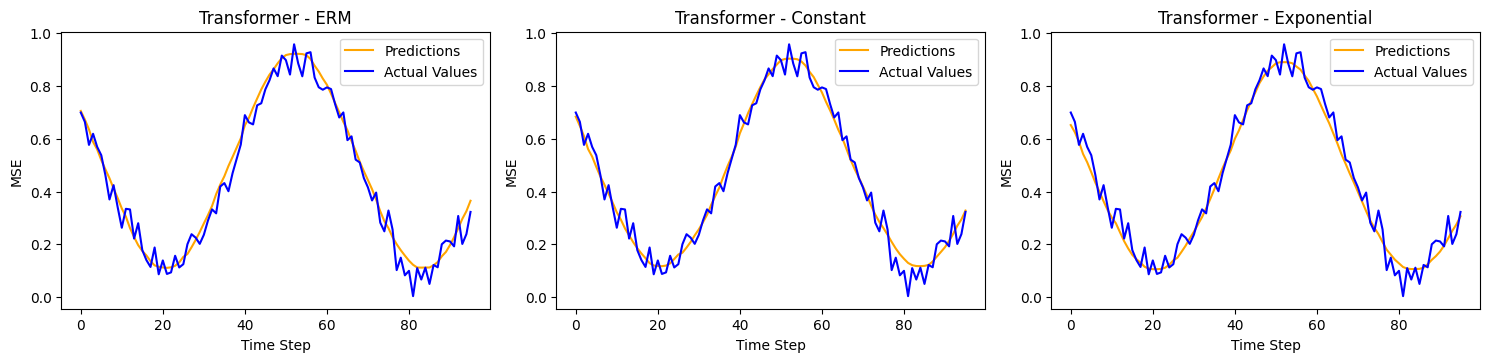

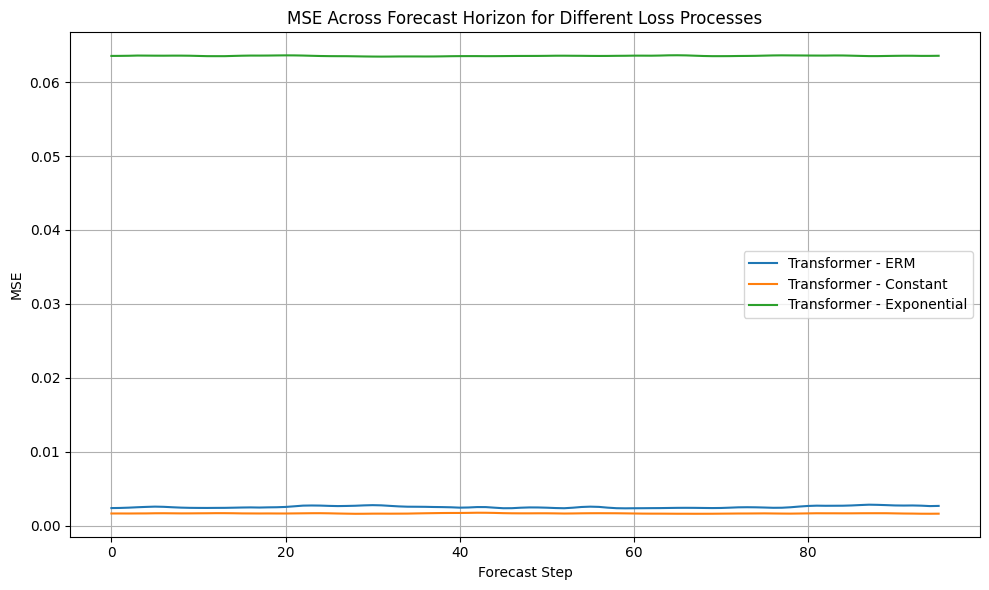

Transformer - ERM: Last MSE = 0.002690606750547886
Transformer - Constant: Last MSE = 0.001639689551666379
Transformer - Exponential: Last MSE = 0.06355401128530502

Transformer - ERM:
Predicted values for the first sample: [ 0.5596595   0.47381794  0.37669808  0.25269365  0.17863312  0.07227705
 -0.01890318 -0.10753924 -0.20870529 -0.30436683 -0.4066738  -0.48894635
 -0.60117954 -0.69069874 -0.77083236 -0.82802975 -0.8724746  -0.929029
 -0.9709914  -0.98463804 -0.99185795 -0.99552333 -0.990384   -0.97506356
 -0.94128525 -0.8863188  -0.8582813  -0.79154664 -0.71937037 -0.64034474
 -0.555138   -0.47310176 -0.382324   -0.265092   -0.17093039 -0.08771922
  0.01433433  0.10366447  0.1956036   0.28692997  0.41683292  0.49282658
  0.59242773  0.68324     0.7733343   0.8494813   0.91897196  0.9723375
  1.0319561   1.0826046   1.1133592   1.12283     1.1259725   1.1256669
  1.1233859   1.1119907   1.0746377   1.0079252   0.950515    0.88041437
  0.8190159   0.7310236   0.63761896  0.5471849   

In [4]:
## Data Preparation and Experiment ----------------------------------------------

def prepare_data(data, context_length, pred_length):
    """Create sequences for time series forecasting"""
    sequences = []
    targets = []
    for i in range(len(data) - context_length - pred_length + 1):
        sequences.append(data[i:i+context_length])
        targets.append(data[i+context_length:i+context_length+pred_length])
    return np.array(sequences), np.array(targets)

def run_experiment(models, loss_processes, data, context_length, pred_length, epochs=10):
    # Prepare data
    X, y = prepare_data(data, context_length, pred_length)

    # Split into train and validation
    split_idx = int(0.8 * len(X))
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_val, y_val = X[split_idx:], y[split_idx:]

    # Convert to tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_val = torch.FloatTensor(X_val)
    y_val = torch.FloatTensor(y_val)

    # Create dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    results = {}

    for model_class in models:
        for process in loss_processes:
            # Initialize model and trainer
            model = model_class(input_dim=1, output_dim=1, pred_length=pred_length)
            trainer = Trainer(model, pred_length, loss_process=process)

            # Train
            train_loss, val_loss = trainer.train(train_loader, val_loader, epochs=epochs)

            # Store results
            key = f"{model_class.__name__}_{process}"
            results[key] = {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'final_step_loss': val_loss[-1],  # Final validation step losses
                'val_loss_per_step': val_loss[-1],
                'predictions': trainer.predict(X_val)  # Predictions for validation set
            }

    return results

def plot_results(results, pred_length, X_val, y_val):
    """Plot the step-wise losses for all models and processes"""
    plt.figure(figsize=(15, 10))

    for i, (key, result) in enumerate(results.items()):
        model_name, process = key.split('_')
        plt.subplot(3, 3, i+1)

        # Get the predictions and actual values
        predictions = result['predictions']
        actual_values = y_val.numpy()

        # Plot first prediction and corresponding actual values
        plt.plot(np.arange(pred_length), predictions[0, :, 0], label="Predictions", color='orange')
        plt.plot(np.arange(pred_length), actual_values[0, :, 0], label="Actual Values", color='blue')

        #plt.plot(result['final_step_loss'], label=process)
        plt.title(f"{model_name} - {process}")
        plt.xlabel('Time Step')
        plt.ylabel('MSE')
        plt.legend()
        #plt.ylim(0, np.max(result['final_step_loss']) * 1.2)

    plt.tight_layout()
    plt.show()

def print_last_mse(results):
    """Print the last MSE value for all models and loss processes"""
    for key, result in results.items():
        model_name, process = key.split('_')
        print(f"{model_name} - {process}: Last MSE = {result['final_step_loss'][-1]}")

def plot_mse_comparison(results, pred_length):
    """Plot the MSE for ERM, Constant, and Exponential loss processes on the same plot."""
    plt.figure(figsize=(10, 6))

    for key, result in results.items():
        model_name, process = key.split('_')

        if process in ['ERM', 'Constant', 'Exponential']:
            if 'val_loss_per_step' in result:
                mse_values = result['val_loss_per_step']  # shape: (pred_length,)
                plt.plot(np.arange(pred_length), mse_values, label=f"{model_name} - {process}")
            else:
                print(f"[Warning] No per-step MSE for {key}, skipping.")

    plt.xlabel('Forecast Step')
    plt.ylabel('MSE')
    plt.title('MSE Across Forecast Horizon for Different Loss Processes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Main Execution ---------------------------------------------------------------

def main():
    # Set random seeds for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    # Generate synthetic time series data
    time = np.arange(0, 1000, 0.1)
    data = np.sin(time) + 0.1 * np.random.randn(len(time))
    data = data.reshape(-1, 1)  # (n_samples, n_features)

    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Experiment parameters
    context_length = 96
    pred_length = 96
    epochs = 20

    # Models to test
    #models = [Transformer, NonstationaryTransformer, Pyraformer, Reformer, Informer, Autoformer]
    #loss_processes = ['ERM', 'Constant', 'Exponential']
    models = [Transformer]
    loss_processes = [ 'ERM', 'Constant', 'Exponential']


    # Run experiment
    results = run_experiment(models, loss_processes, data, context_length, pred_length, epochs)

    # Get X_val and y_val from the run_experiment function
    X, y = prepare_data(data, context_length, pred_length)
    split_idx = int(0.8 * len(X))
    X_val, y_val = X[split_idx:], y[split_idx:]
    X_val = torch.FloatTensor(X_val)
    y_val = torch.FloatTensor(y_val)


    # Plot results
    plot_results(results, pred_length,  X_val, y_val)
    plot_mse_comparison(results, pred_length)


    # Print last MSE values for all models and loss processes
    print_last_mse(results)

    # Print predictions and actual values for all model-loss combinations
    for key, result in results.items():
        model_name, process = key.split('_')
        predictions = result['predictions']
        actual_values = y_val.numpy()
        try:
          actual_values = scaler.inverse_transform(actual_values.reshape(-1, actual_values.shape[-1])).reshape(actual_values.shape)
          predictions = scaler.inverse_transform(predictions.reshape(-1, predictions.shape[-1])).reshape(predictions.shape)
        except:
          print("Skipping inverse transform (scaler not available)")

        print(f"\n{model_name} - {process}:")
        print(f"Predicted values for the first sample: {predictions[0, :, 0]}")
        print(f"Actual values for the first sample: {actual_values[0, :, 0]}")



if __name__ == "__main__":
    main()